In [2]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import random
import matplotlib.pyplot as plt

In [4]:
warnings.filterwarnings('ignore')  
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


**1.Brief description of the problem and data.**

In this exercise, the task is to find signs of tumour using the images from Histopathologic Cancer Detection dataset. The images provided at original source is size 96x96 with rgb channels, however, the existence of tumour sign only in center 32x32 region indicates tumour. Therefore, it is essential to adjust our data in a way that our model doesn't try to match redundant area with the outer space. Since I am going to use zero padding, I will simply discard outer region. This will also help avoid dealing with larger matrix, hence less memory issues. 

In [5]:
image_size = (96, 96)
center_start = 32
center_end = 64

**2.Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data.**

Original pictures are provided in tif form, I use following code to convert the images to numpy arrays. If rgb is set to false, images are converted to grayscale before being converted to numpy arrays. This is again to decrease the size of matrix to run given the memory limit. Free version of Colab provides 12.7 GB RAM which is not enough to handle data with rgb channels included.  I will show below the comparison of clipped images with originals. Also check below other adjustment procedures

In [6]:
def convert_tif_to_numpy(directory, image_size, rgb=True, partition=0.5):
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    if partition is not None:
      tif_files = random.sample(tif_files, int(len(tif_files) * partition)) 

    channels = 3 if rgb else 1
    images_arr = np.zeros((len(tif_files), image_size[0], image_size[1], channels), dtype=np.uint8)
    for ix, f in enumerate(tif_files):
        with Image.open(os.path.join(directory, f)) as img:
            if not rgb:
              img = img.convert('L')
              img_array = np.array(img)
              img_array = np.expand_dims(img_array, -1)
            else:
              img_array = np.array(img)
        images_arr[ix] = img_array
    return images_arr

Adjust here the location of the files with the directory your files are located in

In [7]:
cur_dir = '' # path to working directory

data_dir = os.path.join(cur_dir, 'data') # assuming the files inside zip file are located under data folder. 


In [10]:
# check if the files are in correct place
tif_files = [f for f in os.listdir(os.path.join(data_dir, 'train')) if f.endswith('.tif')]
print(tif_files[0])

d0091d5571cc6d8ab6de8e5a8341b340a52acdb5.tif


I have also added option to image converter to randomly select the data sample from training data if memory cannot handle the operations at this matrix size. We are losing information, however, given the capacity issues, this seems like an only alternative. Overall, two things are done to meet memory capacity: drop rgb channels by converting to grayscale images and select a random smaller sample from original data. I had enough capacity to use entire dataset after clipping images, but had to get rid of rgb channels to make everything ru faster. I also tried with rgb channels, results were very similiar, so we don't lose much information here. 

In [13]:
x_train = convert_tif_to_numpy(directory=os.path.join(data_dir, 'train'), 
                               image_size=image_size, partition=None, rgb=False)



Match filenames  with labels. The order of filenames is not the same with csv file order. 

In [12]:
tif_filenames = [f.replace('.tif','') for f in os.listdir(os.path.join(data_dir, 'train')) if f.endswith('.tif')]
y_train = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))
y_train = y_train.set_index('id').loc[tif_filenames].reset_index()
y_train = y_train['label'].values


All images below are in grayscale. First 10 images include all 96x96 pixels provided in the original dataset, the second 10 images are clipped center 32x32 part of the first 10 images. Titles of the charts indicate if the label is 1 or 0.

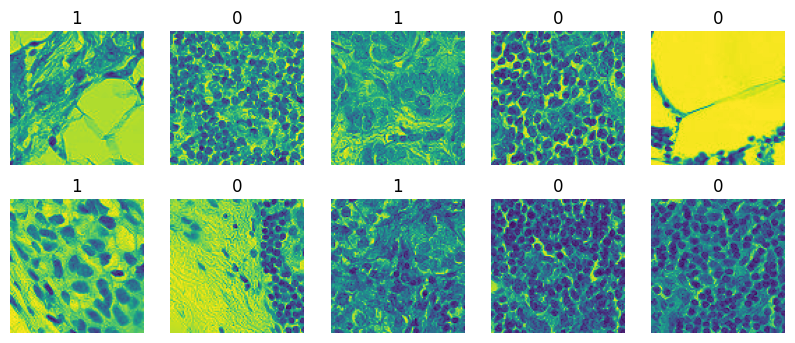

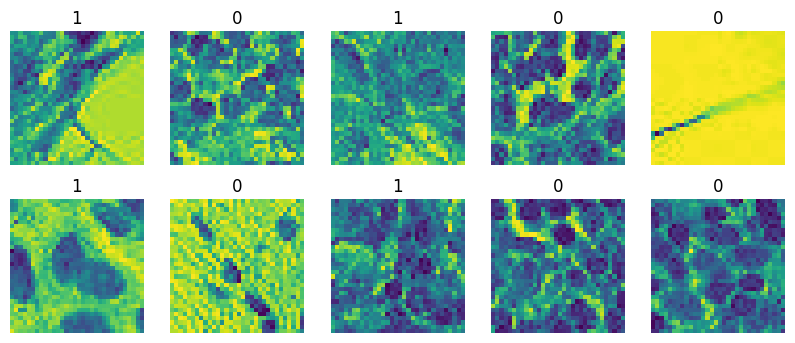

In [14]:
num_images = 10
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i in range(num_images):
    ax = axs[i//5, i%5]
    ax.imshow(x_train[i])
    ax.set_title(str(int(y_train[i])))
    ax.axis('off')

plt.show()

fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i in range(num_images):
    ax = axs[i//5, i%5]
    ax.imshow(x_train[i, center_start:center_end, center_start:center_end])
    ax.set_title(str(int(y_train[i])))
    ax.axis('off')

plt.show()

The values for images in numpy arrays as presented below are in range 0-255 without surprise, thus we can easily do scaling by dividing by 255. 

In [15]:
print(f'Minimum value for dataset is {x_train.min()}')
print(f'Maximum value for dataset is {x_train.max()}')

Minimum value for dataset is 0
Maximum value for dataset is 255


The values for labels are either 0 or 1, thus it is case of binary classification

(array([130908.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  89117.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

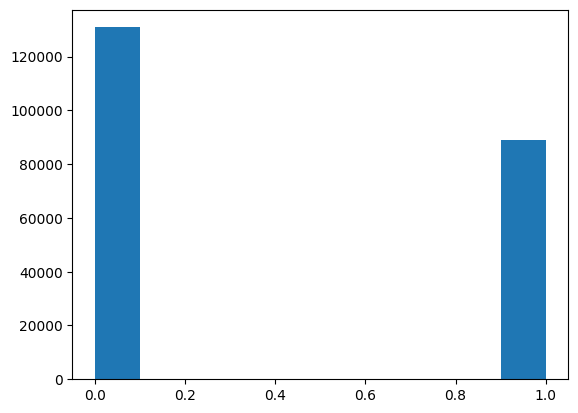

In [16]:
plt.hist(y_train)

Data below are clipped and then scaled to between 0 and 1. Additionally, data type of numpy arrays are converted to float16 again to cope with memory issues, however, this adjustment does not present any significant loss of information due to rounding. 

In [17]:
x_train = x_train[:,center_start:center_end,center_start:center_end]

x_train = x_train.astype(np.float16)/255.0


In [18]:
y_train = y_train.astype(np.float16)

print(x_train.shape)
print(y_train.shape)

(220025, 32, 32, 1)
(220025,)


In [19]:
x_test = convert_tif_to_numpy(directory=os.path.join(data_dir, 'test'), image_size=image_size, rgb=False, partition=None)
x_test = x_test[:,center_start:center_end,center_start:center_end]
x_test = x_test.astype(np.float16)/255.0
print(x_test.shape)

(57458, 32, 32, 1)


In [20]:
def train_valid_split(data: np.ndarray, labels: np.ndarray, train_pct:float=0.8):
    N = data.shape[0]  
    train_indices = np.random.choice(N, int(N*train_pct), replace=False)
    train_data = data[train_indices,:]
    train_labels = labels[train_indices]

    valid_indices = np.setdiff1d(np.arange(N), train_indices)
    valid_data = data[valid_indices,:]   
    valid_labels = labels[valid_indices]
    return train_data, train_labels, valid_data, valid_labels


Instead of using tensorflow, we do train vs validation split here. In this way, we can generate data and save them, then use it in all models instead of having tensorflow doing the split each time. 

In [21]:
x_train, y_train, x_valid, y_valid = train_valid_split(data=x_train, labels=y_train, train_pct=0.8)

In [22]:
np.save(arr=x_train, file=os.path.join(data_dir,'x_train'))
np.save(arr=y_train, file=os.path.join(data_dir,'y_train'))
np.save(arr=x_valid, file=os.path.join(data_dir,'x_valid'))
np.save(arr=y_valid, file=os.path.join(data_dir,'y_valid'))
np.save(arr=x_test, file=os.path.join(data_dir,'x_test'))

Since we are working with big data and if the work is interrupted for some reason, you can just skip the data processing stage by saving the required data for model

In [8]:
# x_train = np.load(os.path.join(data_dir,'x_train.npy'))
# y_train = np.load(os.path.join(data_dir,'y_train.npy'))
# x_valid = np.load(os.path.join(data_dir,'x_valid.npy'))
# y_valid = np.load(os.path.join(data_dir,'y_valid.npy'))
# x_test = np.load(os.path.join(data_dir,'x_test.npy'))

**3.Model Architecture**

Below is a standard convolutional network for binary classification. I will start with shallow model, then gradually activate additional layers. All the models include convolutional block for feature extraction plus 2 Dense block for classification. All the layers except the last Dense layer is using RELU activation function, the last Dense layer uses sigmoid activation function since it is a binary classfication model. The loss function is also binary_cross_entropy with accuracy metrics, the optimizer is set to ADAM with initial max learning rate of 0.001. 

In [10]:
def cancer_detection_model(input_shape, conv_layer_sizes=[32,64], dropout:float=None, batch_norm=True, pool='avg', strides=1):
    padding = "same"
    if pool is not None and pool.lower() in ['avg', 'max']:
        pool_layer = layers.AveragePooling2D if pool.lower()=='avg' else layers.MaxPooling2D
    else:
        pool = None
    inputs = layers.Input(shape=input_shape)
    x = inputs
    for sz in conv_layer_sizes:
        x = layers.Conv2D(sz, 3, strides=strides, padding=padding)(x)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        if dropout:
            x = layers.Dropout(rate=dropout)(x)
    
    if pool is not None:
        x = pool_layer(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(conv_layer_sizes[-1]*2)(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    if dropout:
        x = layers.Dropout(rate=dropout)(x)
    # sigmoid activation function as it is binary classification
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
input_shape = x_train.shape[1:]
batch_size = 64
print(input_shape)


(32, 32, 1)


Initial model includes only 3 convolutional layers with strides set to 1 and no regularizers

In [ ]:

model = cancer_detection_model(input_shape=input_shape, conv_layer_sizes=[32,64,128], dropout=None, batch_norm=False, pool=None)
optimizer = Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

The model includes 2 convolutional layer by default (can be more if user defines more layer sizes) to extract features from the images. All the layers do not include zero padding since the description of dataset suggests that pixels on the corners are provided to work with no zero padding and any cancer tissue found there should not be classified as cancer evidence for this case.

In [32]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 activation_8 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 activation_9 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 activation_10 (Activation)  (None, 32, 32, 128)       0   

In [33]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=50, validation_data=(x_valid, y_valid))

Epoch 1/50


2023-04-05 11:59:13.838652: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-05 11:59:17.445245: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2751/2751 [==============================] - 58s 19ms/step - loss: 0.5136 - accuracy: 0.7549 - val_loss: 0.4989 - val_accuracy: 0.7708
Epoch 2/50
2751/2751 [==============================] - 55s 20ms/step - loss: 0.4731 - accuracy: 0.7837 - val_loss: 0.4717 - val_accuracy: 0.7854
Epoch 3/50
2751/2751 [==============================] - 60s 22ms/step - loss: 0.4487 - accuracy: 0.7966 - val_loss: 0.4711 - val_accuracy: 0.7884
Epoch 4/50
2751/2751 [==============================] - 61s 22ms/step - loss: 0.4047 - accuracy: 0.8205 - val_loss: 0.4841 - val_accuracy: 0.7870
Epoch 5/50
2751/2751 [==============================] - 61s 22ms/step - loss: 0.3191 - accuracy: 0.8646 - val_loss: 0.5710 - val_accuracy: 0.7655
Epoch 6/50
2751/2751 [==============================] - 62s 22ms/step - loss: 0.2052 - accuracy: 0.9192 - val_loss: 0.7983 - val_accuracy: 0.7588
Epoch 7/50
2751/2751 [==============================] - 61s 22ms/step - loss: 0.1183 - accuracy: 0.9561 - val_loss: 1.1441 - val_accura

In [34]:
model.history.history
model.save('my_model_1.h5')

In [18]:
def plot_metrics(history):
    epochs = range(1, len(history['accuracy']) + 1)

    plt.plot(epochs, history['accuracy'], '--b', label='Training accuracy')
    plt.plot(epochs, history['val_accuracy'], '--r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    # Plot training and validation loss
    plt.plot(epochs, history['loss'], '--b', label='Training loss')
    plt.plot(epochs, history['val_loss'], '--r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()



Below we may see that training and validation metrics diverge already after 5 epochs. For 50 epochs, model simply overfits training data with only worsening performance on validation data. 

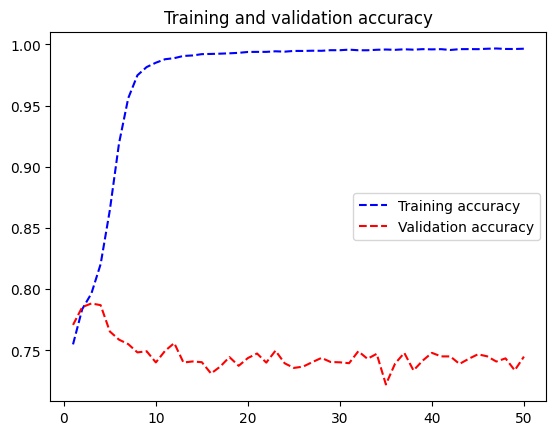

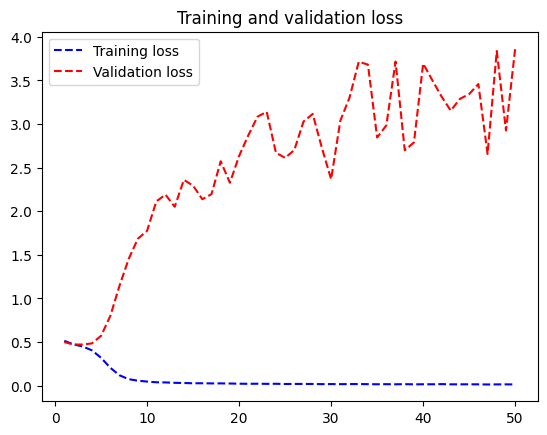

In [44]:
plot_metrics(model.history.history)

The second model includes all in previous model, but additionally dropout layers with 25% dropout. I reduce the epoch size to 15, it already gives enough idea on what is happening

In [45]:
model = cancer_detection_model(input_shape=input_shape, conv_layer_sizes=[32,64,128], dropout=0.25, batch_norm=False,  pool=None)
optimizer = Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 activation_12 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 activation_13 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0   

In [46]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=15, validation_data=(x_valid, y_valid))

Epoch 1/15
2751/2751 [==============================] - 60s 22ms/step - loss: 0.5213 - accuracy: 0.7529 - val_loss: 0.5000 - val_accuracy: 0.7658
Epoch 2/15
2751/2751 [==============================] - 65s 24ms/step - loss: 0.4860 - accuracy: 0.7783 - val_loss: 0.4825 - val_accuracy: 0.7766
Epoch 3/15
2751/2751 [==============================] - 68s 25ms/step - loss: 0.4757 - accuracy: 0.7844 - val_loss: 0.4794 - val_accuracy: 0.7805
Epoch 4/15
2751/2751 [==============================] - 69s 25ms/step - loss: 0.4652 - accuracy: 0.7893 - val_loss: 0.4655 - val_accuracy: 0.7890
Epoch 5/15
2751/2751 [==============================] - 69s 25ms/step - loss: 0.4568 - accuracy: 0.7928 - val_loss: 0.4658 - val_accuracy: 0.7896
Epoch 6/15
2751/2751 [==============================] - 69s 25ms/step - loss: 0.4480 - accuracy: 0.7980 - val_loss: 0.4668 - val_accuracy: 0.7900
Epoch 7/15
2751/2751 [==============================] - 69s 25ms/step - loss: 0.4363 - accuracy: 0.8031 - val_loss: 0.4705 -

In [47]:
model.history.history
model.save('my_model_2.h5')

Dropout makes the model improve on training data more gradually, but the results still diverge after around 5 epochs. Overall, this feature does little on improving model prediction performance

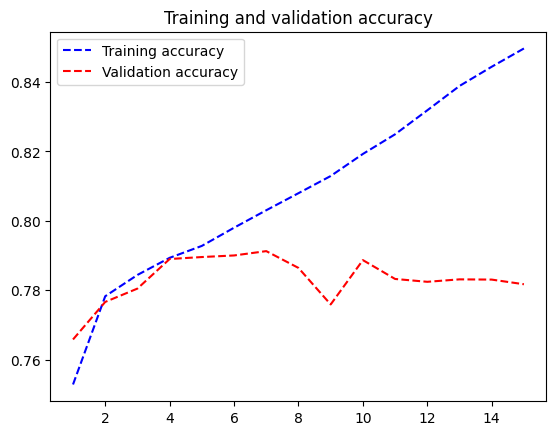

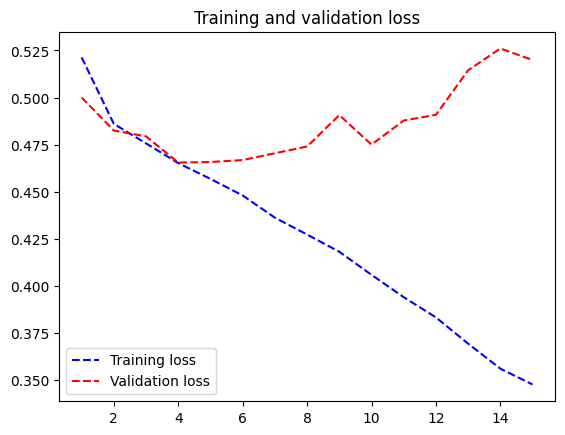

In [48]:
plot_metrics(model.history.history)

The third model includes everything on first model, but additionally batch normalization and average pooling. Strides are set to 2 as well. 

In [49]:
model = cancer_detection_model(input_shape=input_shape, conv_layer_sizes=[32, 64, 128], dropout=0.25, batch_norm=True, 
                               pool='avg',strides=2)
optimizer = Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_16 (Activation)  (None, 16, 16, 32)        0         
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 64)          18496     
                                                           

In [51]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=15, validation_data=(x_valid, y_valid))

Epoch 1/15
2751/2751 [==============================] - 24s 8ms/step - loss: 0.5064 - accuracy: 0.7649 - val_loss: 0.5058 - val_accuracy: 0.7558
Epoch 2/15
2751/2751 [==============================] - 22s 8ms/step - loss: 0.4865 - accuracy: 0.7754 - val_loss: 0.4764 - val_accuracy: 0.7812
Epoch 3/15
2751/2751 [==============================] - 23s 8ms/step - loss: 0.4774 - accuracy: 0.7801 - val_loss: 0.4709 - val_accuracy: 0.7843
Epoch 4/15
2751/2751 [==============================] - 23s 8ms/step - loss: 0.4702 - accuracy: 0.7846 - val_loss: 0.4993 - val_accuracy: 0.7629
Epoch 5/15
2751/2751 [==============================] - 23s 8ms/step - loss: 0.4640 - accuracy: 0.7873 - val_loss: 0.4828 - val_accuracy: 0.7746
Epoch 6/15
2751/2751 [==============================] - 23s 9ms/step - loss: 0.4591 - accuracy: 0.7901 - val_loss: 0.5111 - val_accuracy: 0.7591
Epoch 7/15
2751/2751 [==============================] - 23s 9ms/step - loss: 0.4554 - accuracy: 0.7923 - val_loss: 0.4508 - val_ac

In [ ]:
model.history.history
model.save('my_model_3.h5')

This model performs much better than the previous models, with more epochs we could see the validation accuracy changes around 0.79 after 10 epochs, and train and validation dataset metrics improve close to each other until then. I will use this model as the main one and compare it with a Resnet example.

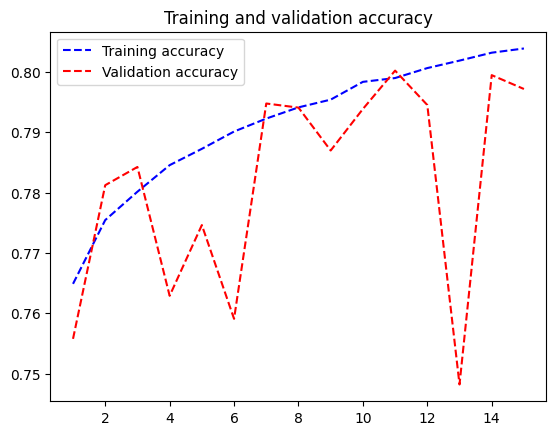

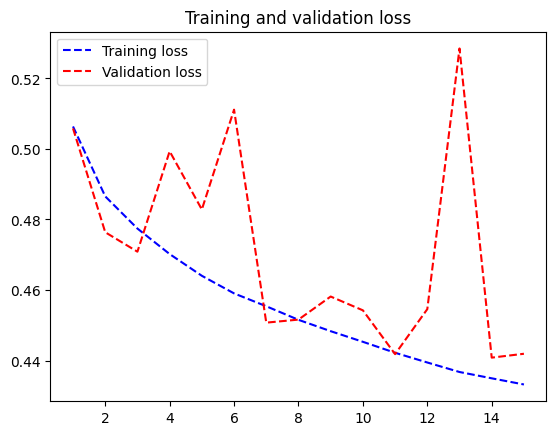

In [52]:
plot_metrics(model.history.history)

**4.Results and Analysis**

Below is an implementation of resnet. I switched softmax to sigmoid to make them comparable. Also adjusted parts of code to run with new version of tensorflow.

In [12]:
# source: https://gist.github.com/JefferyRPrice/c1ecc3d67068c8d9b3120475baba1d7e
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from tensorflow.keras.regularizers import l2

def rnpa_bottleneck_layer(input_tensor, nb_filters, filter_sz, stage,
    init='glorot_normal', reg=0.0, use_shortcuts=True):

    nb_in_filters, nb_bottleneck_filters = nb_filters

    bn_name = 'bn' + str(stage)
    conv_name = 'conv' + str(stage)
    relu_name = 'relu' + str(stage)
    merge_name = 'add' + str(stage)

    # batchnorm-relu-conv, from nb_in_filters to nb_bottleneck_filters via 1x1 conv
    if stage>1: # first activation is just after conv1
        x = BatchNormalization(axis=1, name=bn_name+'a')(input_tensor)
        x = Activation('relu', name=relu_name+'a')(x)
    else:
        x = input_tensor

    x = Conv2D(
            nb_bottleneck_filters,
            kernel_size=(1, 1),
            strides=1,
            padding='same',
            kernel_initializer=init,
            kernel_regularizer=l2(reg),
            use_bias=False,
            name=conv_name+'a'
        )(x)
    # batchnorm-relu-conv, from nb_bottleneck_filters to nb_bottleneck_filters via FxF conv
    x = BatchNormalization(axis=1, name=bn_name+'b')(x)
    x = Activation('relu', name=relu_name+'b')(x)
    x = Conv2D(
            nb_bottleneck_filters, filter_sz, padding='same',
            kernel_initializer=init,
            kernel_regularizer=l2(reg),
            use_bias=False,
            name=conv_name+'b'
        )(x)

    # batchnorm-relu-conv, from nb_in_filters to nb_bottleneck_filters via 1x1 conv
    x = BatchNormalization(axis=1, name=bn_name+'c')(x)
    x = Activation('relu', name=relu_name+'c')(x)
    x = Conv2D(nb_in_filters, 1, 1,
            kernel_initializer=init, kernel_regularizer=l2(reg),
            name=conv_name+'c')(x)

    # merge
    if use_shortcuts:
        x = layers.Add(name=merge_name)([x, input_tensor])

    return x


def ResNetPreAct(input_shape=(3,32,32),
        layer1_params=(5,64,2),
        res_layer_params=(3,16,3),
        final_layer_params=None,
        init='glorot_normal', reg=0.0, use_shortcuts=True
    ):
    """
    Return a new Residual Network using full pre-activation based on the work in
    "Identity Mappings in Deep Residual Networks"  by He et al
    http://arxiv.org/abs/1603.05027
    The following network definition achieves 92.0% accuracy on CIFAR-10 test using
    `adam` optimizer, 100 epochs, learning rate schedule of 1e.-3 / 1.e-4 / 1.e-5 with
    transitions at 50 and 75 epochs:
    ResNetPreAct(layer1_params=(3,128,2),res_layer_params=(3,32,25),reg=reg)
    
    Removed max pooling and using just stride in first convolutional layer. Motivated by
    "Striving for Simplicity: The All Convolutional Net"  by Springenberg et al
    (https://arxiv.org/abs/1412.6806) and my own experiments where I observed about 0.5%
    improvement by replacing the max pool operations in the VGG-like cifar10_cnn.py example
    in the Keras distribution.
    
    Parameters
    ----------
    input_dim : tuple of (C, H, W)
    layer1_params: tuple of (filter size, num filters, stride for conv)
    res_layer_params: tuple of (filter size, num res layer filters, num res stages)
    final_layer_params: None or tuple of (filter size, num filters, stride for conv)
    init: type of weight initialization to use
    reg: L2 weight regularization (or weight decay)
    use_shortcuts: to evaluate difference between residual and non-residual network
    """

    sz_L1_filters, nb_L1_filters, stride_L1 = layer1_params
    sz_res_filters, nb_res_filters, nb_res_stages = res_layer_params
    
    use_final_conv = (final_layer_params is not None)
    if use_final_conv:
        sz_fin_filters, nb_fin_filters, stride_fin = final_layer_params
        sz_pool_fin = input_shape[1] / (stride_L1 * stride_fin)
    else:
        sz_pool_fin = input_shape[1] / (stride_L1)


    img_input = Input(shape=input_shape, name='cifar')

    x = layers.Conv2D(
        filters=nb_L1_filters, 
        kernel_size=sz_L1_filters,
        padding='same', 
        strides=stride_L1,
        kernel_initializer=init,
        kernel_regularizer=l2(reg),
        use_bias=False,
        name='conv0'
    )(img_input)
    x = BatchNormalization(axis=1, name='bn0')(x)
    x = Activation('relu', name='relu0')(x)

    for stage in range(1,nb_res_stages+1):
        x = rnpa_bottleneck_layer(
                x,
                (nb_L1_filters, nb_res_filters),
                sz_res_filters, 
                stage,
                init=init, 
                reg=reg, 
                use_shortcuts=use_shortcuts
            )


    x = BatchNormalization(axis=1, name='bnF')(x)
    x = Activation('relu', name='reluF')(x)

    if use_final_conv:
        x = Conv2D(
                nb_fin_filters, sz_fin_filters, sz_fin_filters,
                padding='same',
                strides= stride_fin,
                kernel_initializer=init,
                kernel_regularizer=l2(reg),
                name='convF',
                use_bias=False
            )(x)

    x = AveragePooling2D((sz_pool_fin,sz_pool_fin), name='avg_pool')(x)

    x = Flatten(name='flat')(x)
    x = Dense(1, activation='sigmoid', name='fc10')(x) # this part is adjusted

    return Model(img_input, x, name='rnpa')

In [14]:
model = ResNetPreAct(input_shape=(32,32,1))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "rnpa"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cifar (InputLayer)             [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv0 (Conv2D)                 (None, 16, 16, 64)   1600        ['cifar[0][0]']                  
                                                                                                  
 bn0 (BatchNormalization)       (None, 16, 16, 64)   64          ['conv0[0][0]']                  
                                                                                                  
 relu0 (Activation)             (None, 16, 16, 64)   0           ['bn0[0][0]']                    
                                                                                               

In [15]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=50, validation_data=(x_valid, y_valid))

Epoch 1/50


2023-04-05 14:49:48.149218: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-05 14:49:50.760806: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2751/2751 [==============================] - 36s 11ms/step - loss: 0.5030 - accuracy: 0.7647 - val_loss: 0.5255 - val_accuracy: 0.7398
Epoch 2/50
2751/2751 [==============================] - 32s 12ms/step - loss: 0.4861 - accuracy: 0.7752 - val_loss: 0.4944 - val_accuracy: 0.7759
Epoch 3/50
2751/2751 [==============================] - 27s 10ms/step - loss: 0.4779 - accuracy: 0.7799 - val_loss: 0.5274 - val_accuracy: 0.7493
Epoch 4/50
2751/2751 [==============================] - 29s 10ms/step - loss: 0.4714 - accuracy: 0.7829 - val_loss: 0.4663 - val_accuracy: 0.7877
Epoch 5/50
2751/2751 [==============================] - 29s 11ms/step - loss: 0.4665 - accuracy: 0.7858 - val_loss: 0.4891 - val_accuracy: 0.7774
Epoch 6/50
2751/2751 [==============================] - 29s 11ms/step - loss: 0.4627 - accuracy: 0.7874 - val_loss: 0.4594 - val_accuracy: 0.7901
Epoch 7/50
2751/2751 [==============================] - 31s 11ms/step - loss: 0.4594 - accuracy: 0.7900 - val_loss: 0.4600 - val_accura

In [16]:
model.history.history
model.save('my_model_resnet.h5')

Similiar to the main model, Resnet diverges after 10-15 moves. However, in both models, validation accuracy shows sign of converge unlike the first two models where validation loss would continously increase while training data overfits. The results of resnet are very similiar to main model. The main difference of resnet example (except more layers) is the skip connection

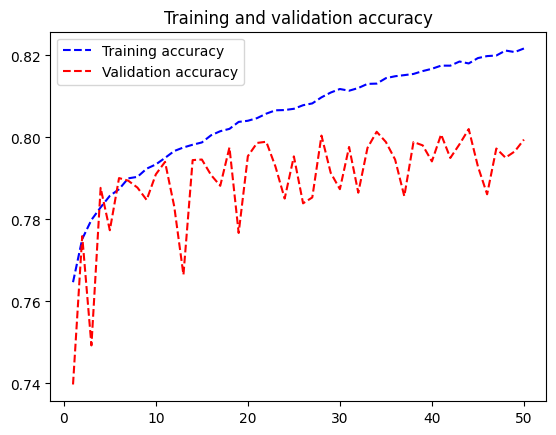

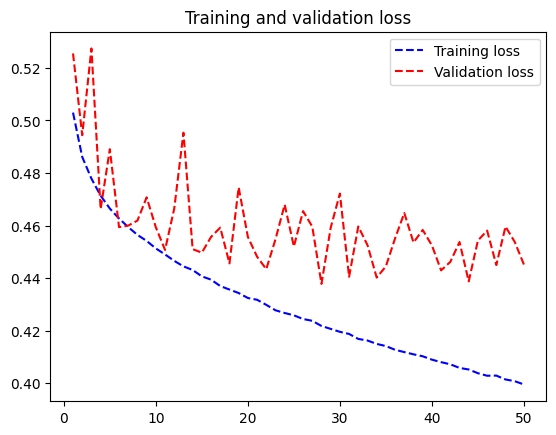

In [19]:
plot_metrics(model.history.history)

In [24]:
model = cancer_detection_model(input_shape=input_shape, conv_layer_sizes=[32, 64, 128], dropout=0.25, batch_norm=True, 
                               pool='avg',strides=2)
optimizer = Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                             

In [25]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=10, validation_data=(x_valid, y_valid))

Epoch 1/10
2751/2751 [==============================] - 22s 8ms/step - loss: 0.5074 - accuracy: 0.7643 - val_loss: 0.5571 - val_accuracy: 0.7279
Epoch 2/10
2751/2751 [==============================] - 18s 7ms/step - loss: 0.4862 - accuracy: 0.7752 - val_loss: 0.4910 - val_accuracy: 0.7735
Epoch 3/10
2751/2751 [==============================] - 19s 7ms/step - loss: 0.4768 - accuracy: 0.7803 - val_loss: 0.4832 - val_accuracy: 0.7745
Epoch 4/10
2751/2751 [==============================] - 20s 7ms/step - loss: 0.4692 - accuracy: 0.7855 - val_loss: 0.4723 - val_accuracy: 0.7806
Epoch 5/10
2751/2751 [==============================] - 20s 7ms/step - loss: 0.4629 - accuracy: 0.7895 - val_loss: 0.4631 - val_accuracy: 0.7867
Epoch 6/10
2751/2751 [==============================] - 20s 7ms/step - loss: 0.4592 - accuracy: 0.7913 - val_loss: 0.4591 - val_accuracy: 0.7910
Epoch 7/10
2751/2751 [==============================] - 20s 7ms/step - loss: 0.4544 - accuracy: 0.7936 - val_loss: 0.4572 - val_ac

In [26]:
model.history.history
model.save('my_model_final.h5')

We run the main model again with 10 epochs before we apply metrics.

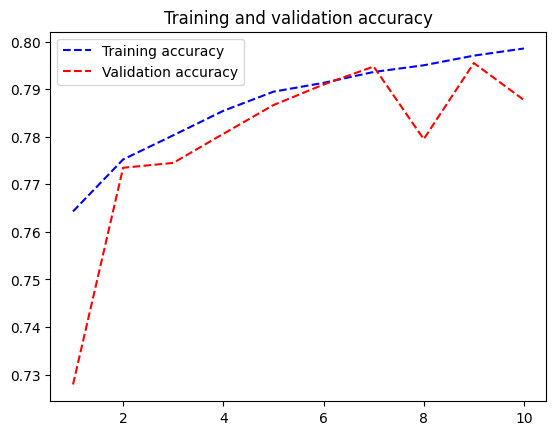

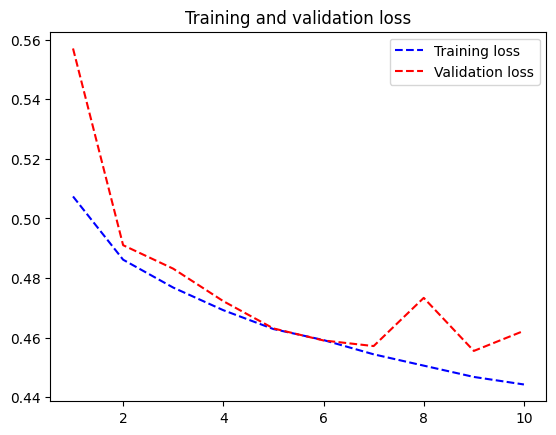

In [27]:
plot_metrics(model.history.history)

In [11]:
# from tensorflow import keras
# model = keras.models.load_model('my_model_1.h5')

**5.Conclusion**

Prepare the dataset to be checked on Kaggle

In [28]:
y_test_pred = model.predict(x_test)

1796/1796 [==============================] - 3s 2ms/step


In [29]:
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
labels =  tif_files = [f.replace('.tif','') for f in os.listdir(os.path.join(data_dir, 'test')) if f.endswith('.tif')]
df = pd.DataFrame(data=y_test_pred, index=labels)


In [22]:
df.head()

,0
c81867d08e5ef799c0fdb0473d79106af4f521ca,1
3f5572a538bab0bb0f7cd0e5609573fee63739fb,0
3fd0ba3fbb7cdfee2042b980ba9276db36c2e0aa,0
1db7fe9a3aad8037201522798d803ed70516e6a6,0
1c767f2d0e594841c44e9bbcbe9cc80343f3a869,1


In [30]:
df.to_csv(os.path.join(data_dir, 'test_labels.csv'))

Results below show that the prediction accuracy of resnet and the main model are very similiar as expected. Overall, it does help to add regularizers, but we should also adjust epoch limit to prevent overfitting

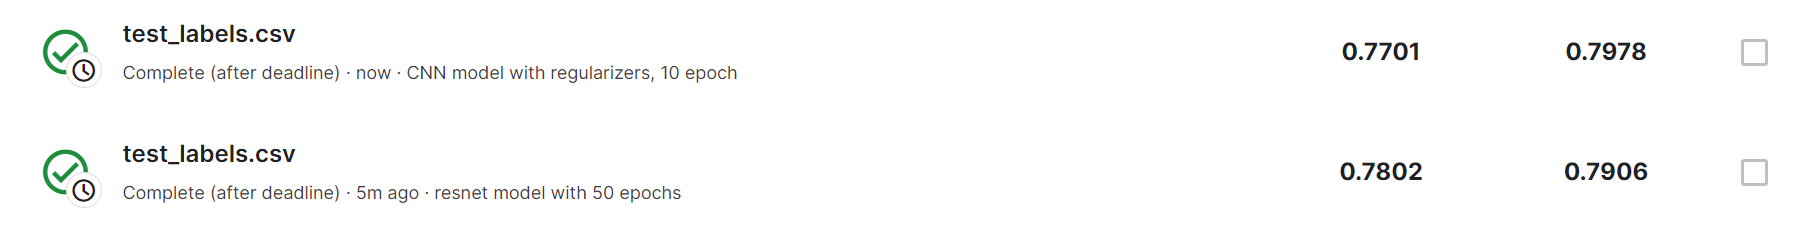

In [31]:
from IPython.display import Image
Image(filename=os.path.join(data_dir,'rsults.png'))